# aux-17 Count pois in aoi

This notebook __extracts statistical data from available pois__ in order to manually classify them as __'very frequent', 'frequent', 'rare' and 'very rare'__. This classification has an impact on HQSL_v2. The obtained data is:
1. Total count of available points of interest in area of interest
2. count_15min average
3. count_15min max

Data varies depending on source (few sources need special treatment)

## __Import libraries__

In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## __Notebook config__

#### Directories

In [15]:
# General directory where all input data (pois) are located
gral_dir = '../../../data/external/temporal_fromjupyter/santiago/pois/'

# Directory where output (pois count) will be saved
save_dir = '../../../data/external/temporal_fromjupyter/santiago/pois/'

#### Parameters dictionary

In [5]:
# --- REQUIRED DATA: parameters dictionary
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado'#Accessibility to supermarkets
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital_priv','hospital_pub',#Accessibility to hospital
                                          'clinica_priv','clinica_pub',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio_priv','vacunatorio_pub',#Accessibility to vaccination center
                                          'consult_ado_priv','consult_ado_pub',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo_pub','eq_deportivo_priv',#Accessibility to sports equipments
                                            'club_deportivo',#Accessibility to sport clubs
                                            'police'#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                           ],
                             'environmental_impact':['bomberos'#Accessibility to fire stations
                                                     #Not available: Air polution
                                                     #Not available: Accessibility to street lamp
                                                    ]
                            },
                   'living':{'wellbeing':['ep_plaza_small',#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                          'ep_plaza_big',#Accessibility to big parks
                                          #Not available: Number of street bentches
                                          #Not available: Noise
                                         ],
                             'sociability':['civic_office',#Accessibility to civic offices
                                            'viv_count',#Accessibility to permanent residencies
                                            'viv_social_count',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            #Not available: Accessibility to places of workship
                                            'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                            'social_security',#ANSES: SOCIAL SECURITY
                                            'correos',#ADDED: MAIL SERVICE
                                            'hotel_count'#ADDED: HOTELS
                                           ],
                             'environmental_impact':[#Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                     #Not available: Street connectivity
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos_priv','museos_pub',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias'#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                             ],
                               'environmental_impact':['ndvi_count'#Number of trees
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            #Not available: Accessibility to Childcare
                                            'universidad',#Accessibility to university
                                            'jardin_inf_pub',#'jardin_inf_priv',#ADDED: KINDERGARDENS
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['banco',#Accessibility to bank (###MOVED FROM LIVING TO WORKING)
                                           'oficinas_count',#Accessibility to office
                                           'paradas_tp',#Accessibility to bus stop
                                           'paradas_tp_metro','paradas_tp_tren'#Accessibility to metro/tram/train stop
                                          ],
                              'sociability':[#Not available: Accessibility to incubators
                                             #Not available: Accessibility to coworking places
                                          ],
                              'environmental_impact':['ciclovias'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

#### List of pois that require different processing

In [45]:
# Suma de ID unicos
id_poi_list = ['ferias','ep_plaza_small','ep_plaza_big','ciclovias']

#Se toma el dato de la columna de interés.
# ndvi_count es ndvi_mean.
different_poi_list = ['viv_count','viv_social_count','hotel_count','ndvi_count','oficinas_count']

## __Load data__

### __Load data__ - Area of interest

<Axes: >

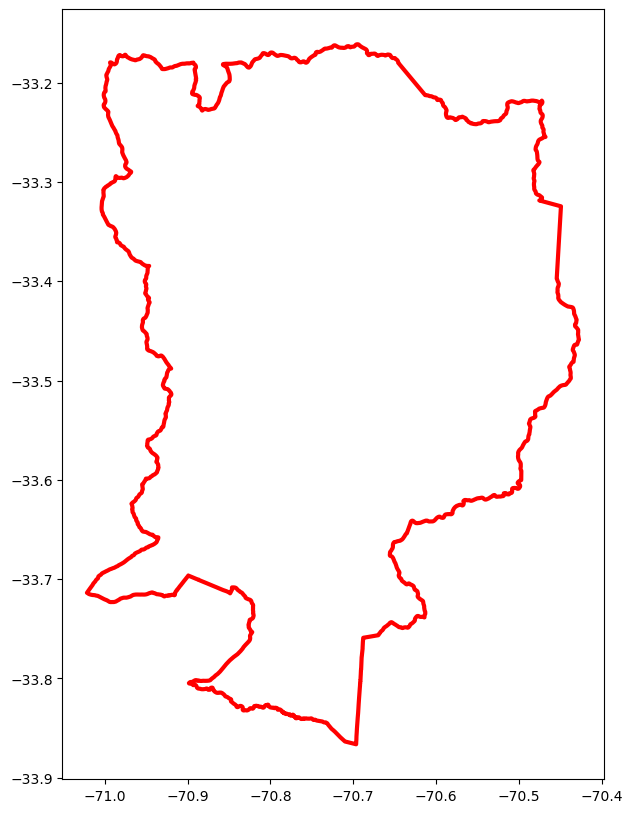

In [14]:
# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
city = 'AM_Santiago'

# Area of interest (aoi)
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# Show
fig,ax = plt.subplots(figsize=(10,10))
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

### __Load data__ - Proximity data

In [62]:
prox_schema = 'projects_research'
prox_table = 'santiago_hexproximity_hqsl_4_5_kmh_pub'
res = 9

query = f"SELECT * FROM {prox_schema}.{prox_table} WHERE res = {res}"
prox_gdf = aup.gdf_from_query(query, geometry_col='geometry')
prox_gdf = prox_gdf.set_crs("EPSG:4326")

# Show
print(prox_gdf.shape)
prox_gdf.head(1)

(9121, 201)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.001,53.321742,0.001,63.057446,0.001,173.61823,0.001,...,0.0,4.8333,7.238974,1.509034,0.0,0.0,0.0,0.0,0.0,3.155563


## __Data statistics__

In [23]:
source_list = []
for social_function in parameters_dict:
    for indicator in parameters_dict[social_function]:
        for source in parameters_dict[social_function][indicator]:
            source_list.append(source)

source_list

['carniceria',
 'hogar',
 'bakeries',
 'supermercado',
 'ferias',
 'local_mini_market',
 'centro_recyc',
 'hospital_priv',
 'hospital_pub',
 'clinica_priv',
 'clinica_pub',
 'farmacia',
 'vacunatorio_priv',
 'vacunatorio_pub',
 'consult_ado_priv',
 'consult_ado_pub',
 'salud_mental',
 'labs_priv',
 'residencia_adumayor',
 'eq_deportivo_pub',
 'eq_deportivo_priv',
 'club_deportivo',
 'police',
 'bomberos',
 'ep_plaza_small',
 'ep_plaza_big',
 'civic_office',
 'viv_count',
 'viv_social_count',
 'tax_collection',
 'social_security',
 'correos',
 'hotel_count',
 'museos_priv',
 'museos_pub',
 'cines',
 'sitios_historicos',
 'restaurantes_bar_cafe',
 'librerias',
 'ndvi_count',
 'edu_basica_pub',
 'edu_media_pub',
 'universidad',
 'jardin_inf_pub',
 'edu_tecnica',
 'edu_adultos_pub',
 'edu_especial_pub',
 'bibliotecas',
 'centro_edu_amb',
 'banco',
 'oficinas_count',
 'paradas_tp',
 'paradas_tp_metro',
 'paradas_tp_tren',
 'ciclovias']

### __Data statistics__ - Statistics for regular pois

In [65]:
regular_pois_df = pd.DataFrame()

i = 0
for source in source_list:
    if (source not in id_poi_list) and (source not in different_poi_list):

        # ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
        # Load original source data
        # For sources that have both _priv and _pub, measure together. (Except labs_priv, which just has _priv)
        if ('_priv' in source) and ('labs' not in source):
            source.replace('priv','')
            
            pois_dir = gral_dir + f'{source}.gpkg'

        else:
            pois_dir = gral_dir + f'{source}.gpkg'
            pois = gpd.read_file(pois_dir)
        
        # Set CRS for spatial join
        try:
            pois = pois.set_crs("EPSG:4326")
        except:
            pois = pois.to_crs("EPSG:4326")
        
        # Clip pois to aoi
        source_pois = gpd.sjoin(pois, aoi)

        # Register data
        regular_pois_df.loc[i,'metric'] = source
        regular_pois_df.loc[i,'total'] = source_pois.shape[0]

        # ------------------------------ AVERAGE AND MAX COUNT_15MIN
        regular_pois_df.loc[i,'mean_15min_count'] = prox_gdf[f'{source}_count_15min'].mean()
        regular_pois_df.loc[i,'max_15min_count'] = prox_gdf[f'{source}_count_15min'].max()
        
        i+=1

regular_pois_df

,metric,total,mean_15min_count,max_15min_count
0,carniceria,775.0,0.914431,10.001000
1,hogar,1185.0,1.308955,27.001000
2,bakeries,915.0,2.362388,50.353941
3,supermercado,515.0,1.220469,14.629205
4,local_mini_market,3049.0,4.104691,94.211526
5,centro_recyc,1239.0,2.916607,24.743857
6,hospital_priv,6.0,0.017556,2.001000
7,hospital_pub,29.0,0.068726,4.905762
8,clinica_priv,234.0,0.587289,19.613245
9,clinica_pub,333.0,0.710039,5.601000


### __Data statistics__ - Statistics for unique ID pois

In [66]:
unique_id_pois_df = pd.DataFrame()

i = 0
for source in source_list:
    if source in id_poi_list:
        print(f"Processing statistics for {source}.")

        # ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
        # Load original source data
        pois_dir = gral_dir + f'{source}.gpkg'
        pois = gpd.read_file(pois_dir)
        
        # Set CRS for spatial join
        try:
            pois = pois.set_crs("EPSG:4326")
        except:
            pois = pois.to_crs("EPSG:4326")
        
        # Clip pois to aoi
        source_pois = gpd.sjoin(pois, aoi)

        # Register data
        unique_id_pois_df.loc[i,'metric'] = source
        unique_id_pois_df.loc[i,'total'] = len(pois.ID.unique())

        # ------------------------------ AVERAGE AND MAX COUNT_15MIN
        unique_id_pois_df.loc[i,'mean_15min_count'] = prox_gdf[f'{source}_count_15min'].mean()
        unique_id_pois_df.loc[i,'max_15min_count'] = prox_gdf[f'{source}_count_15min'].max()
        
        i+=1

unique_id_pois_df

Processing statistics for ferias.
Processing statistics for ep_plaza_small.
Processing statistics for ep_plaza_big.
Processing statistics for ciclovias.


,metric,total,mean_15min_count,max_15min_count
0,ferias,433.0,1.378915,8.367667
1,ep_plaza_small,9442.0,19.827778,100.953381
2,ep_plaza_big,1424.0,3.956553,20.419919
3,ciclovias,449.0,2.029659,23.778778


### __Data statistics__ - Statistics for vivienda

In [68]:
special_pois_df = pd.DataFrame()

In [69]:
source = 'viv_count'
original_source_name = 'casas_deptos_mzn'
col_of_interest = 'total_viv'
i = 0

# ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
# Load original source data
pois_dir = gral_dir + f'{original_source_name}.gpkg'
pois = gpd.read_file(pois_dir)

# Set CRS for spatial join
try:
    pois = pois.set_crs("EPSG:4326")
except:
    pois = pois.to_crs("EPSG:4326")

# Clip pois to aoi
source_pois = gpd.sjoin(pois, aoi)

# Register data
special_pois_df.loc[i,'metric'] = source
special_pois_df.loc[i,'total'] = source_pois[col_of_interest].sum()

# ------------------------------ AVERAGE AND MAX COUNT_15MIN
special_pois_df.loc[i,'mean_15min_count'] = prox_gdf[f'{source}'].mean()
special_pois_df.loc[i,'max_15min_count'] = prox_gdf[f'{source}'].max()

special_pois_df

,metric,total,mean_15min_count,max_15min_count
0,viv_count,2.204748e+06,9.760018,397.25831


### __Data statistics__ - Statistics for hotels

In [84]:
source = 'hotel_count'
original_source_name = 'usos_de_suelo'
i = 1

# ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
# Load original source data
pois_dir = gral_dir + f'{original_source_name}.gpkg'
pois = gpd.read_file(pois_dir)

# Set CRS for spatial join
try:
    pois = pois.set_crs("EPSG:4326")
except:
    pois = pois.to_crs("EPSG:4326")

# Clip pois to aoi
source_pois = gpd.sjoin(pois, aoi)

# Calculate %area corresponding to HOTEL in all city
all_uses = ['ADMIN','AGR','BBCC','BODEG','COM','CULT','DEPOR','EDUC','ERIAZO',
            'ESTAC','HABIT','HOTEL','INDUS','MIN','OFIC','OTROS','SALUD','TPTE']
source_pois['tot_area'] = source_pois[all_uses].sum(axis=1)
pct_hotel_area = source_pois['HOTEL'].sum()/source_pois['tot_area'].sum()

# Register data
special_pois_df.loc[i,'metric'] = source
special_pois_df.loc[i,'city_mean_pct'] = pct_hotel_area

# ------------------------------ AVERAGE AND MAX PCT AREA CORRESPONDING TO HOTEL BY HEX

# Group node data by hex adding hotel area and total area
hex_gdf = prox_gdf[['hex_id','res','geometry']].copy()
source_pois.drop(columns=['index_right'],inplace=True)
pois_hex = gpd.sjoin(source_pois, hex_gdf)
groupby = pois_hex.groupby('hex_id').agg({'HOTEL':np.sum,'tot_area':np.sum})

# Calculate percentage corresponding to hotel from total area
groupby['pct_hotel_area'] = groupby['HOTEL']/groupby['tot_area']

special_pois_df.loc[i,'hex_mean_pct'] = groupby['pct_hotel_area'].mean()
special_pois_df.loc[i,'hex_max_pct'] = groupby['pct_hotel_area'].max()

special_pois_df

,metric,total,mean_15min_count,max_15min_count,count,city_mean_pct,hex_mean_pct,hex_max_pct
0,viv_count,2.204748e+06,9.760018,397.25831,NaN,NaN,NaN,NaN
1,hotel_count,NaN,NaN,NaN,0.004691,0.004691,0.001925,0.298763


### __Data statistics__ - Statistics for social housing

In [ ]:
different_poi_list = ['viv_count','viv_social_count','hotel_count','ndvi_count','oficinas_count']


special_pois_df = pd.DataFrame()

i = 0
for source in source_list:
    if source in different_poi_list:
        print(f"Processing statistics for {source}.")

        # ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
        if source == 'viv_count':
            original_source_name = 
        
        # Load original source data
        pois_dir = gral_dir + f'{source}.gpkg'
        pois = gpd.read_file(pois_dir)
        
        # Set CRS for spatial join
        try:
            pois = pois.set_crs("EPSG:4326")
        except:
            pois = pois.to_crs("EPSG:4326")
        
        # Clip pois to aoi
        source_pois = gpd.sjoin(pois, aoi)

        # Register data
        special_pois_df.loc[i,'metric'] = source
        special_pois_df.loc[i,'count'] = len(pois.ID.unique())

        # ------------------------------ AVERAGE AND MAX COUNT_15MIN
        special_pois_df.loc[i,'mean_count'] = prox_gdf[f'{source}_count_15min'].mean()
        special_pois_df.loc[i,'max_count'] = prox_gdf[f'{source}_count_15min'].max()
        
        i+=1

unique_id_pois_df

In [55]:
source = 'viv_count'
original_source_name = 'usos_de_suelo'
i = 0

# ------------------------------ TOTAL COUNT OF POINTS OF INTEREST IN AREA OF INTEREST
# Load original source data
pois_dir = gral_dir + f'{original_source_name}.gpkg'
pois = gpd.read_file(pois_dir)

pois

,osmid,ADMIN,AGR,BBCC,BODEG,COM,CULT,DEPOR,EDUC,ERIAZO,ESTAC,HABIT,HOTEL,INDUS,MIN,OFIC,OTROS,SALUD,TPTE,geometry
0,386139,0.000000,0.0,0.520425,163.909199,769.964416,27.715437,0.0,13.781373,0.0,0.000000,203.073595,14.213205,0.107459,0.0,887.353986,30.780062,0.199923,0.000000,POINT (-70.64725 -33.44313)
1,386140,0.000000,0.0,0.000000,0.114390,0.532323,0.000000,0.0,0.000000,0.0,0.000000,0.130597,0.000000,0.000000,0.0,0.618872,0.021155,0.000000,0.000000,POINT (-70.64767 -33.44304)
2,386145,0.000000,0.0,0.330547,13.610690,16.141610,0.000000,0.0,0.047653,0.0,2.254077,3.703342,4.619344,0.000000,0.0,25.911293,1.048373,0.000000,0.000000,POINT (-70.64897 -33.44334)
3,386147,0.000000,0.0,0.000000,29.034082,42.907665,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,11.550857,0.000000,0.000000,497.502925,POINT (-70.65038 -33.44367)
4,386157,246.004843,0.0,75.769293,5059.843077,2859.185157,836.111929,0.0,0.000000,0.0,5331.392013,11779.607685,326.578346,0.000000,0.0,15047.200692,874.817593,2.203585,0.000000,POINT (-70.65840 -33.43695)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229960,11948456749,0.000000,0.0,0.000000,270.567076,132.714388,0.000000,0.0,0.000000,0.0,122.566304,174.317512,0.000000,0.000000,0.0,286.626996,0.000000,0.000000,0.000000,POINT (-70.57857 -33.38853)
229961,11948456750,0.000000,0.0,0.000000,1.846727,0.000000,0.000000,0.0,0.000000,0.0,3.684866,1225.562554,0.000000,0.000000,0.0,0.000000,5.753115,0.000000,0.000000,POINT (-70.58108 -33.38722)
229962,11948456751,0.000000,0.0,0.000000,0.117343,0.000000,0.000000,0.0,0.000000,0.0,0.202394,34.448896,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,POINT (-70.58176 -33.38687)
229963,11948456753,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.041608,2.028535,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,POINT (-70.58185 -33.38682)
